In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
from tqdm import tqdm, trange
from math import sqrt,sin,cos
from numpy import array
from numpy import linspace,zeros,float64
%matplotlib inline

In [26]:
!tar -xvf gym-traj_tar.xz 

gym-traj/
gym-traj/gym_traj/
gym-traj/gym_traj/__init__.py
gym-traj/gym_traj/envs/
gym-traj/gym_traj/envs/__init__.py
gym-traj/gym_traj/envs/traj_env.py
gym-traj/gym_traj/envs/__pycache__/
gym-traj/gym_traj/envs/__pycache__/__init__.cpython-37.pyc
gym-traj/gym_traj/envs/__pycache__/traj_env.cpython-37.pyc
gym-traj/gym_traj/__pycache__/
gym-traj/gym_traj/__pycache__/__init__.cpython-37.pyc
gym-traj/setup.py
gym-traj/gym_traj.egg-info/
gym-traj/gym_traj.egg-info/PKG-INFO
gym-traj/gym_traj.egg-info/dependency_links.txt
gym-traj/gym_traj.egg-info/requires.txt
gym-traj/gym_traj.egg-info/top_level.txt
gym-traj/gym_traj.egg-info/SOURCES.txt


In [27]:
!pip install -e /content/gym-traj

Obtaining file:///content/gym-traj
  Found existing installation: gym-traj 0.0.1
    Can't uninstall 'gym-traj'. No files were found to uninstall.
  Running setup.py develop for gym-traj


In [0]:
import gym
import gym_traj

# Pretraining

In [0]:
def circle(t):
    r = 0.4
    x = r*sin(-0.02*t)
    y = r*cos(-0.02*t)+0.9
    vx = r*0.02*cos(-0.02*t)
    vy = -r*0.02*sin(-0.02*t)
    return [x, y, vx, vy]

def Lyapunov_control(x, y, vx, vy, wanted_x, wanted_y, wanted_vx, wanted_vy, param):
    """
    param["k1"], param["k2"]: linear coefs
    """
    k1, k2 = param["k1"], param["k2"]
    ax = -k1*(x - wanted_x)-k2*(vx + wanted_vx)
    ay = -k1*(y - wanted_y)-k2*(vy + wanted_vy)
    return [ax, ay]

MAX_ACC = 0.36538
def motionL(t, listState, trajectory, control, control_param):
    [x, y, vx, vy] = listState;

    if (x < -0.82)and(vx < 0):
        vx = 0
    if (x > 0.82)and(vx > 0):
        vx = 0    
    if (y < 0)and(vy < 0):
        vy = 0
    if (y > 1.61)and(vy > 0):
        vy = 0
    
    wanted_x, wanted_y, wanted_vx, wanted_vy = trajectory(t)
    index_arr = control(x, y, vx, vy, wanted_x, wanted_y, wanted_vx, wanted_vy, param = control_param)
    ind = np.argmax(index_arr)
    ax0, ay0 = action_set[ind]
    
    u = st_X(x,y)
    v = st_Y(x,y)
    
    if ax0**2 + ay0**2 > MAX_ACC*2:
        [ax, ay] = [MAX_ACC*ax0/sqrt(ax0**2 + ay0**2)+u, MAX_ACC*ay0/sqrt(ax0**2 + ay0**2)+v]
    else:
        [ax, ay] = [ax0+u, ay0+v]
    return array([vx, vy, ax, ay]), array([ax0, ay0])

MAX_ACC = 0.36538
def motion(t, listState, trajectory, control, control_param):
    [x, y, vx, vy] = listState;

    if (x < -0.82)and(vx < 0):
        vx = 0
    if (x > 0.82)and(vx > 0):
        vx = 0    
    if (y < 0)and(vy < 0):
        vy = 0
    if (y > 1.61)and(vy > 0):
        vy = 0
    
    wanted_x, wanted_y, wanted_vx, wanted_vy = trajectory(t)
    ax0, ay0 = control(x, y, vx, vy, wanted_x, wanted_y, wanted_vx, wanted_vy, param = control_param)
    
    u = st_X(x,y)
    v = st_Y(x,y)
    
    if ax0**2 + ay0**2 > MAX_ACC*2:
        [ax, ay] = [MAX_ACC*ax0/sqrt(ax0**2 + ay0**2)+u, MAX_ACC*ay0/sqrt(ax0**2 + ay0**2)+v]
    else:
        [ax, ay] = [ax0+u, ay0+v]
        
    return array([vx, vy, ax, ay]), array([ax0, ay0])

def motion_without_perp(t , listState, trajectory, control, control_param):
    [x, y, vx, vy] = listState;

    if (x < -0.82)and(vx < 0):
        vx = 0
    if (x > 0.82)and(vx > 0):
        vx = 0    
    if (y < 0)and(vy < 0):
        vy = 0
    if (y > 1.61)and(vy > 0):
        vy = 0
    
    wanted_x, wanted_y, wanted_vx, wanted_vy = trajectory(t)
    ax0, ay0 = control(x, y, vx, vy, wanted_x, wanted_y, wanted_vx, wanted_vy, param = control_param)
    
    u = 0
    v = 0
    
    if ax0**2 + ay0**2 > 0.36538**2:
        [ax, ay] = [0.36538*ax0/sqrt(ax0**2 + ay0**2)+u, 0.36538*ay0/sqrt(ax0**2 + ay0**2)+v]
    else:
        [ax, ay] = [ax0+u, ay0+v]
        
    return array([vx, vy, ax, ay]), array([ax0, ay0])

def ode4(ode, tspan, y0, k, trajectory, control, control_param):
    [t0, tf] = tspan
    h=(tf-t0)/k
    T = linspace(t0,tf,num = k+1, dtype = np.double)
    nrowsT = len(T)
    nrowsy0 = len(y0)
    Y = zeros((nrowsT,nrowsy0),dtype = np.double)
    acc = zeros((nrowsT, 2))
    
    Y[0][:] = y0[:]
    for i in range(1,nrowsT,1):
        t  = T[i-1]
        y  = Y[i-1][:]
        h  = T[i] - T[i-1]
        k1, acc[i-1, :] = ode(t,y,trajectory,control, control_param)
        k2, _ = ode(t+0.5*h,y+0.5*h*k1,trajectory,control, control_param)
        k3, _ = ode(t+h/2.0,y+0.5*h*k2,trajectory,control, control_param)
        k4, _ = ode(t+h,y+h*k3,trajectory,control, control_param)
        yn = y+(1.0/6.0)*h*(k1+2.0*k2+2.0*k3+k4)
        Y[i][:] = yn
    return [T, Y, acc]

def deep_control(*state, param):
    """
    param["model"]: trained neural net
    param["var"]: variance of normal noize with shape (2,)
    do not define this keyword if you want to get unnoized result
    """
    state_t = Tensor(np.array(state)).view(1, -1)
    res = param["model"](convert_to_variable(state_t))
    res = res.cpu().data.numpy()[0]
    if "var" in param.keys():
        res += np.random.normal(scale = param["var"], size = 2)
    elif "add" in param.keys():
        res += next(param["add"])
    return res

def st_X(x,y):
    p00 =    -0.01311
    p10 =    0.009422 
    p01 =     -0.0276
    p20 =      0.1476
    p11 =    -0.04613
    p02 =      0.2377
    p30 =     -0.1103
    p21 =     -0.2451
    p12 =      0.1946
    p03 =     -0.4666
    p40 =     -0.1914
    p31 =     0.06507
    p22 =      0.4069
    p13 =     -0.2008
    p04 =      0.3505
    p50 =     0.07237
    p41 =     0.04237
    p32 =    -0.01276
    p23 =     -0.1806
    p14 =     0.05798
    p05 =    -0.09046
    return p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 + p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5

def st_Y(x,y):
    p00 =     0.04728
    p10 =    -0.03281
    p01 =     -0.4472
    p20 =    -0.09362
    p11 =       0.397
    p02 =       1.532
    p30 =    -0.02768
    p21 =      0.4174
    p12 =      -1.004
    p03 =      -2.566
    p40 =     0.06433
    p31 =      0.1234
    p22 =     -0.5461
    p13 =      0.8732
    p04 =       1.959
    p50 =    0.001958
    p41 =    -0.06374
    p32 =    -0.09306  
    p23 =      0.2182
    p14 =     -0.2402
    p05 =     -0.5396
    return p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 + p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5



In [34]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
DoubleTensor = torch.cuda.DoubleTensor if use_gpu else torch.DoubleTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = DoubleTensor

Using GPU


In [0]:
model = nn.Sequential(
        nn.Linear(8, 32),
        nn.ReLU(),
    
        nn.Linear(32, 32),
        nn.Sigmoid(),
    
        nn.Linear(32, 2),
).type(Tensor)

if use_gpu:
    model.cuda()

In [0]:
def loss_pretrain(target, predicted):
    return ((target - predicted)**2).sum()

In [0]:
DotQuan = 1800
Time = 900

tm = [0, Time]
y0 = array([-0.5, 1.2, 0.0, 0.0])
K = {"k1": 0.12, "k2": 0.68}
def get_batches_pretrain(trajectory, batch_size, batch_num):
    for n_batch in range(batch_num):
        inp = np.random.rand(batch_size, 8)*1.6 - np.array([0.8, 0, 0.8, 0.8, 0.8, 0, 0.8, 0.8])
        out = np.array([Lyapunov_control(*x, K) for x in inp])
        
        if use_gpu:
            inp, out = Tensor(inp).cuda(), Tensor(out).cuda()
        else:
            inp, out = Tensor(inp), Tensor(out)
        yield inp, out

In [0]:
n_epochs = 60
batch_size = 32
batch_num = 1
opt = torch.optim.Adam(model.parameters(), 2e-4)

def pretraining(model, optimizer, n_epochs = n_epochs, batch_size = batch_size, batch_num = batch_num):
    model.train(True)
    for epoch in tqdm(range(n_epochs)):
        for x, y in get_batches_pretrain(circle, batch_size, batch_num):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_pretrain(y, y_pred)
            loss.backward()
            optimizer.step()
    return model 

In [39]:
pretrained_model = pretraining(model, opt, 10000, 256, 1);

100%|██████████| 10000/10000 [00:22<00:00, 443.11it/s]


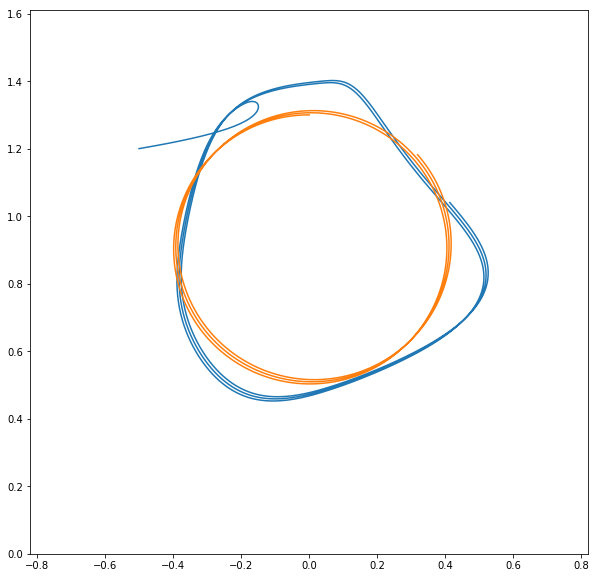

In [40]:
yid = np.array([circle(t) for t in np.linspace(0, Time, DotQuan+1)])

pretrained_model.eval()
[T, y_pre, ACCC] = ode4(motion,tm,y0,DotQuan,circle, deep_control, {"model": pretrained_model});
plt.figure(figsize = (10, 10))

ns1 = np.random.randn(1801)*0.00001
ns2 = np.sin(np.arange(1801)*0.00001)

plt.plot(y_pre[:,0]+ns2, y_pre[:,1]+ns2)
plt.plot(yid[:, 0]+ns2, yid[:, 1]+ns2)
plt.xlim((-0.82, 0.82))
plt.ylim((0, 1.61))
plt.show()

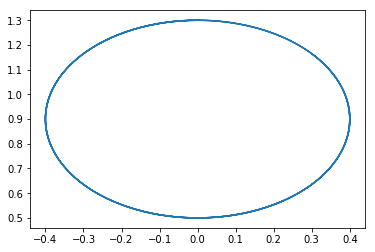

In [42]:
env = gym.make('Traj-v0')
env.action_set = ACCC
env.reset()
n_actions = env.action_space.n
# plt.imshow(env.render("rgb_array"))
#env.close()

In [0]:
def convert_to_variable(x, grad=True):
    return Variable(torch.FloatTensor(x), requires_grad=grad)

# pick an action using epsilon greedy policy
def epsilon_greedy(q_values, epsilon):
    q_values = q_values.data.numpy()
    action = 0
    if np.random.rand() <= epsilon:
        action = np.random.randint(0, 2)
    else:
        action = np.argmax(q_values)
    return action

# xavier uniform weight initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# print gradients of network (for debugging)
def print_gradients(net):
    for param in net.parameters():
        print(param.grad)

# given rewards of an episode, get discounted returns
def get_discounted_returns(eps_rew):
    returns = []
    running_ret = 0
    for rew in reversed(eps_rew):
        ret = rew + 0.95 * running_ret
        returns.append(ret)
        running_ret = ret 
    return convert_to_variable(list(reversed(returns)), False)

# naive policy gradient update
def pg_update(optimizer, criterion, eps_rew, eps_probs, eps_targets):
    discounted_returns = get_discounted_returns(eps_rew)
    eps_targets = torch.argmax(eps_targets, dim=1)
    pg_loss = criterion(eps_probs, eps_targets)
    pg_loss = discounted_returns*pg_loss
    optimizer.zero_grad()
    pg_loss.sum().backward()
    optimizer.step()

# simple policy network
# returns probability of each action
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.main = nn.Sequential(
                nn.Linear(8, 30),
                nn.ReLU(True),
                nn.Linear(30, 25),
                nn.ReLU(True),
                nn.Linear(25, env.action_space.n)
            )

    def forward(self, X):
        o = self.main(X)
        return o

# train agent
def train(net, env, optimizer):
    epsilon = 1.0
    criterion = nn.CrossEntropyLoss(reduce=False, size_average=True)
    for episode in range(10000):
        # reset environment for new episode
        s = env.reset()
        done = False
        t = 0
        eps_rew = []
        eps_probs = None
        eps_targets = None

        # while episode is not finished
        while not done:

            # pick an action using epsilon greedy policy
            probs = net(convert_to_variable(s))
            probs = probs[None, :]
            a = epsilon_greedy(probs, epsilon)

            # get next state and reward from env
            # env.render()
            next_s, rew, done, _ = env.step(a)
            rew = rew if not done else -10

            # build target for policy gradient
            target = torch.zeros(probs.shape)
            target[0, a] = 1

            # store episode rewards, actions probabilities and targets
            eps_targets = torch.cat((eps_targets, target), 0) if eps_targets is not None else target
            eps_probs = torch.cat((eps_probs, probs), 0) if eps_probs is not None else probs
            eps_rew.append(rew)
            
            # move to next state
            s = next_s
            t = t + 1

        # update network after each episode with naive policy gradient
        pg_update(optimizer, criterion, eps_rew, eps_probs, eps_targets)
        env.model = net

        # decrease exploration with time
        if epsilon > 0.01: # keep 0.01 as minimum epsilon value
            epsilon = epsilon * 0.995
        print("Episode %d finished after %d timesteps, epsilon = %f" % (episode+1, t, epsilon))
    return net

def main():
    

    # initialization
    torch.manual_seed(2) # optional
    env = gym.make('Traj-v0')
    env.action_set = ACCC
    net = PolicyNet()
    net.apply(init_weights)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    # train naive pg agent
    net = train(net, env, optimizer)
    
    return net

if __name__ == '__main__':
    net = main()
    torch.save(net.state_dict(), 'checkpoint.pth.tar')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Episode 1 finished after 1000 timesteps, epsilon = 0.995000
Episode 2 finished after 1000 timesteps, epsilon = 0.990025
Episode 3 finished after 1000 timesteps, epsilon = 0.985075
Episode 4 finished after 1000 timesteps, epsilon = 0.980150
Episode 5 finished after 1000 timesteps, epsilon = 0.975249
Episode 6 finished after 1000 timesteps, epsilon = 0.970373
Episode 7 finished after 1000 timesteps, epsilon = 0.965521
Episode 8 finished after 1000 timesteps, epsilon = 0.960693
Episode 9 finished after 1000 timesteps, epsilon = 0.955890
Episode 10 finished after 1000 timesteps, epsilon = 0.951110
Episode 11 finished after 1000 timesteps, epsilon = 0.946355
Episode 12 finished after 1000 timesteps, epsilon = 0.941623
Episode 13 finished after 1000 timesteps, epsilon = 0.936915
Episode 14 finished after 1000 timesteps, epsilon = 0.932230
Episode 15 finished after 1000 timesteps, epsilon = 0.927569
Episode 16 finished after 1000 timesteps, epsilon = 0.922931
Episode 17 finished after 1000 ti

/content/gym-traj/gym_traj/envs/traj_env.py:263: RuntimeWarning: overflow encountered in double_scalars
/content/gym-traj/gym_traj/envs/traj_env.py:263: RuntimeWarning: invalid value encountered in double_scalars
/content/gym-traj/gym_traj/envs/traj_env.py:287: RuntimeWarning: overflow encountered in double_scalars
/content/gym-traj/gym_traj/envs/traj_env.py:287: RuntimeWarning: invalid value encountered in double_scalars


Episode 289 finished after 1000 timesteps, epsilon = 0.234893
Episode 290 finished after 1000 timesteps, epsilon = 0.233719
Episode 291 finished after 1000 timesteps, epsilon = 0.232550
Episode 292 finished after 1000 timesteps, epsilon = 0.231387
Episode 293 finished after 1000 timesteps, epsilon = 0.230230
Episode 294 finished after 1000 timesteps, epsilon = 0.229079
Episode 295 finished after 1000 timesteps, epsilon = 0.227934
Episode 296 finished after 1000 timesteps, epsilon = 0.226794
Episode 297 finished after 1000 timesteps, epsilon = 0.225660
Episode 298 finished after 1000 timesteps, epsilon = 0.224532
Episode 299 finished after 1000 timesteps, epsilon = 0.223409
Episode 300 finished after 1000 timesteps, epsilon = 0.222292
Episode 301 finished after 1000 timesteps, epsilon = 0.221181
Episode 302 finished after 1000 timesteps, epsilon = 0.220075
Episode 303 finished after 1000 timesteps, epsilon = 0.218974
Episode 304 finished after 1000 timesteps, epsilon = 0.217880
Episode 

In [0]:
def convert_to_variable(x, grad=True):
    return Variable(torch.FloatTensor(x.cpu().clone().numpy()), requires_grad=grad)

In [0]:
def deep_control(*state, param):
    """
    param["model"]: trained neural net
    param["var"]: variance of normal noize with shape (2,)
    do not define this keyword if you want to get unnoized result
    """
    state_t = Tensor(np.array(state)).view(1, -1)
    res = param["model"](convert_to_variable(state_t))
    res = res.cpu().data.numpy()[0]
    if "var" in param.keys():
        res += np.random.normal(scale = param["var"], size = 2)
    elif "add" in param.keys():
        res += next(param["add"])
    return res

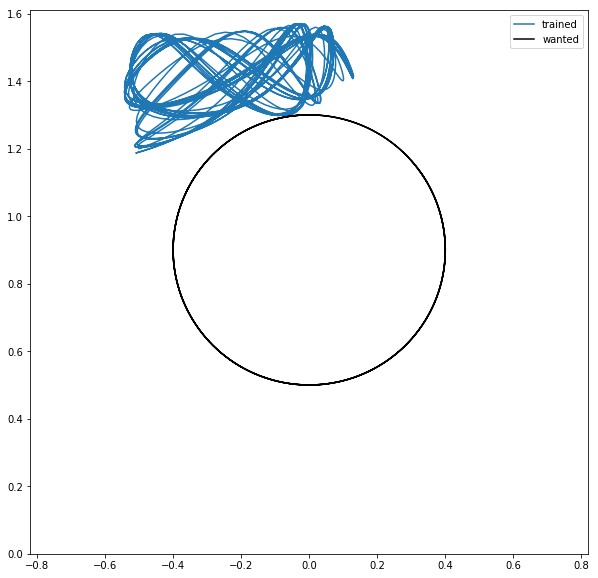

In [54]:
model = PolicyNet()
model.load_state_dict(torch.load('checkpoint.pth.tar'))
model.eval()
action_set = ACCC
_, y, _ = ode4(motionL, [0, Time], y0, DotQuan, circle, deep_control, {"model": model});

plt.figure(figsize = (10, 10))

plt.plot(y[:,0], y[:,1], label = "trained")
plt.plot(yid[:,0], yid[:,1], color = "black", label = "wanted")
plt.legend()
plt.xlim((-0.82, 0.82))
plt.ylim((0, 1.61))
plt.show()